# Agent Executor 

In [2]:
import boto3

In [3]:
!pip3 install langchain-aws langchain-community langchain --quiet

In [4]:
from botocore.config import Config
from langchain_aws import ChatBedrock
bedrock_region = 'us-east-1'
modelId = "anthropic.claude-3-sonnet-20240229-v1:0"
boto3_bedrock = boto3.client(
    service_name='bedrock-runtime',
    region_name=bedrock_region,
    config=Config(
        retries = {
            'max_attempts': 30
        }            
    )
)

HUMAN_PROMPT = "\n\nHuman:"
AI_PROMPT = "\n\nAssistant:"
maxOutputTokens = 4096
parameters = {
    "max_tokens":maxOutputTokens,     
    "temperature":0.1,
    "top_k":250,
    "top_p":0.9,
    "stop_sequences": [HUMAN_PROMPT]
}    
chat = ChatBedrock(   
    model_id=modelId,
    client=boto3_bedrock, 
    model_kwargs=parameters,
)

In [5]:
from langchain.memory import ConversationBufferWindowMemory
memory_chain = ConversationBufferWindowMemory(memory_key="chat_history", output_key='answer', return_messages=True, k=10)

In [6]:
import getpass
import os

In [7]:
langsmith_api_key = getpass.getpass("Password:")

Password: ········


In [8]:
os.environ["LANGCHAIN_API_KEY"] = langsmith_api_key
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Agent Executor From Scratch"

## Tavily Search

In [9]:
api_key = getpass.getpass("Password:")

Password: ········


In [10]:
os.environ["TAVILY_API_KEY"] = api_key

In [11]:
!pip install -U tavily-python --quiet

In [12]:
from langchain_community.tools.tavily_search import TavilySearchResults
search = TavilySearchResults(k=5)
search.invoke("강남 맛집은?")

[{'url': 'https://m.blog.naver.com/twin_couple/222831691893',
  'content': '강남역 맛집 내돈내산 14군데 모음 (3탄) 2022. 7. 28. 6:40. #직장인 #점심 먹으러 자주가는 #강남역 #맛집 #정리! #식당 선정 필요할 때, #메뉴 고민될 때 나를 위해 해보는 간단한 #강남역 #맛집 #내돈내산 #기록 #모음~ 벌써 3탄이네;;;ㅋㅋ 내 기준 맛집은 #맛집 으로, 그 ...'},
 {'url': 'https://www.siksinhot.com/toplists/best/101767_gangnam',
  'content': '점심 시간에 방문하기 좋은 강남역 맛집. 매일 직송하는 좋은 한우 등심을 맛볼 수 있는 곳으로 평양냉면, 설화등심 꽃등심 전문점으로 벽제갈비에서 직영하고 있습니다. 싱싱한 육회 및 전골요리와 한우특양탕도 인기입니다. 그릇. 강남역주변에서 직장인들이 ...'},
 {'url': 'https://m.blog.naver.com/ldi25/221201986790',
  'content': '그래도 다행인건리얼맛집은 아니여도 예쁜 인테리어와 일정수준의 맛을 내는 곳들이 많으니 갈곳은 많죠\n※ 본 컨텐츠에 대한 저작권은모두 ""바이디"" 에게 있으므로무단 도용 및 불펌을 절대 금지 합니다.※\n★2018년 4월 이달의 블로그 선정★\n이 블로그\n외부\n카테고리 글\n카테고리\n이 블로그\n외부\n카테고리 글 블로그\n카테고리 이동\nSarcastic Movie LAB "바이디"\n[강남역] 내가 다시 가고 싶은 맛집 BEST 17\n2018. 기념일 같을 때 데이트하기 좋은 곳입니다.음식맛도 깔끔하고 플레이팅도 괜찮습니다.가격대는 강남역 레스토랑들과 비슷한듯...\n강남역에는 음식점들이 정말 많이 있습니다.많은 음식점들을 다녀보고 깨달은 점은 맛이 굉장히 비슷한 수준의 음식점들이 많다는 점입니다. 개인적으로떡볶이를 별로 좋아하지 않는데 주변에 가본여자분들이 좋아하시길래 선정해 봤습

## Chat Agent Executor 
https://github.com/langchain-ai/langgraph/blob/main/examples/chat_agent_executor_with_function_calling/base.ipynb

### Agent Sate 사용시

In [60]:
import operator
from typing import Annotated, Sequence, TypedDict

from langchain_core.messages import BaseMessage

In [61]:
tools = [TavilySearchResults(max_results=1)]

In [62]:
tools = [TavilySearchResults(max_results=1)]
tool_node = ToolNode(tools)

In [63]:
model = chat.bind_tools(tools)

In [66]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

In [67]:
# Define the function that determines whether to continue or not
def should_continue(state):
    messages = state["messages"]
    last_message = messages[-1]
    if not last_message.tool_calls:
        return "end"
    else:
        return "continue"

In [68]:
# Define the function that calls the model
def call_model(state):
    messages = state["messages"]
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}

In [69]:
# Define a new graph
workflow = StateGraph(AgentState)

workflow.add_node("agent", call_model)
workflow.add_node("action", tool_node)

workflow.add_edge(START, "agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "continue": "action",
        "end": END,
    },
)

workflow.add_edge("action", "agent")

app = workflow.compile()

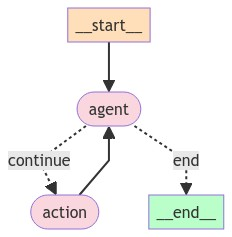

In [70]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [76]:
from langchain_core.messages import HumanMessage

inputs = {"messages": [HumanMessage(content="서울과 제주의 날씨 비교해줘.")]}
app.invoke(inputs)

{'messages': [HumanMessage(content='서울과 제주의 날씨 비교해줘.'),
  AIMessage(content='', additional_kwargs={'usage': {'prompt_tokens': 281, 'completion_tokens': 109, 'total_tokens': 390}, 'stop_reason': 'tool_use', 'model_id': 'anthropic.claude-3-sonnet-20240229-v1:0'}, response_metadata={'usage': {'prompt_tokens': 281, 'completion_tokens': 109, 'total_tokens': 390}, 'stop_reason': 'tool_use', 'model_id': 'anthropic.claude-3-sonnet-20240229-v1:0'}, id='run-d5189cfa-75eb-4655-8536-a3120e1e669d-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'seoul weather'}, 'id': 'toolu_bdrk_01BX5We6R8tU1YTt6CYmGz1k'}], usage_metadata={'input_tokens': 281, 'output_tokens': 109, 'total_tokens': 390}),
  ToolMessage(content='[{"url": "https://www.weatherapi.com/", "content": "{\'location\': {\'name\': \'Seoul\', \'region\': \'\', \'country\': \'South Korea\', \'lat\': 37.57, \'lon\': 127.0, \'tz_id\': \'Asia/Seoul\', \'localtime_epoch\': 1720629617, \'localtime\': \'2024-07-11 1:40\'}, \'

In [71]:
from langchain_core.messages import HumanMessage

inputs = [HumanMessage(content="강남역 맛집 알려줘")]

for event in app.stream({"messages": inputs}, stream_mode="values"):    
    event["messages"][-1].pretty_print()

================================ Human Message =================================

강남역 맛집 알려줘
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (toolu_bdrk_01L98GMQda3oE52VbLRcYYDW)
 Call ID: toolu_bdrk_01L98GMQda3oE52VbLRcYYDW
  Args:
    query: 강남역 맛집
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.siksinhot.com/taste?upHpAreaId=9&hpAreaId=33", "content": "Pho vi cay, \ub9e4\uc6b4 \ucabd\uac08\ube44 \uc300\uad6d\uc218, \ub9e4\uc6b4 \uc6b0\uc0bd\uacb9 \uc300\uad6d\uc218, \uc6b0\uc0bc\uacb9 \uc300\uad6d\uc218\n11014\n4\n9\n2801\n1\n5\n\ub77c\ube0c\ub9ac\ud06c \uc5d0\uadf8 \ubaa8\ub2dd\ubc00, \ub77c\ube0c\ub9ac\ud06c \ubc84\ud130\ubc00, \uba38\uc26c\ub8f8 \uc5d0\uadf8 \uc0cc\ub4dc\uc704\uce58\n2893\n0\n1\n\ub7f0\uce58\uc624\ub9c8\uce74\uc138, \ub514\ub108\uc624\ub9c8\uce74\uc138\n1317\n0\n3\nMamas Signature, Ricotta Cheese Salad,

### Message Sate 사용시

In [13]:
tools = [TavilySearchResults(max_results=1)]

In [14]:
import operator
from typing import Annotated, TypedDict, Union

from langchain_core.agents import AgentAction, AgentFinish
from langchain_core.messages import BaseMessage

In [15]:
from langchain_core.tools import tool
from langgraph.graph import MessagesState, START
from langgraph.prebuilt import ToolNode
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver

In [16]:
tools = [TavilySearchResults(max_results=1)]
tool_node = ToolNode(tools)

In [53]:
# Set up the model

model = chat.bind_tools(tools)

In [54]:
# Define the function that determines whether to continue or not
def should_continue(state):
    messages = state["messages"]
    last_message = messages[-1]
    if not last_message.tool_calls:
        return "end"
    else:
        return "continue"

In [55]:
# Define the function that calls the model
def call_model(state):
    messages = state["messages"]
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}

In [56]:
# Define a new graph
workflow = StateGraph(MessagesState)

workflow.add_node("agent", call_model)
workflow.add_node("action", tool_node)

workflow.add_edge(START, "agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "continue": "action",
        "end": END,
    },
)

workflow.add_edge("action", "agent")

app = workflow.compile()

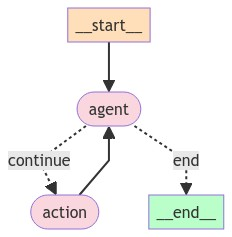

In [57]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [58]:
from langchain_core.messages import HumanMessage

inputs = [HumanMessage(content="강남역 맛집 알려줘")]

for event in app.stream({"messages": inputs}, stream_mode="values"):    
    event["messages"][-1].pretty_print()

================================ Human Message =================================

강남역 맛집 알려줘
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (toolu_bdrk_016Tmp8havhN1UvGHibWZTGH)
 Call ID: toolu_bdrk_016Tmp8havhN1UvGHibWZTGH
  Args:
    query: 강남역 맛집
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.siksinhot.com/taste?upHpAreaId=9&hpAreaId=33", "content": "Pho vi cay, \ub9e4\uc6b4 \ucabd\uac08\ube44 \uc300\uad6d\uc218, \ub9e4\uc6b4 \uc6b0\uc0bd\uacb9 \uc300\uad6d\uc218, \uc6b0\uc0bc\uacb9 \uc300\uad6d\uc218\n11014\n4\n9\n2801\n1\n5\n\ub77c\ube0c\ub9ac\ud06c \uc5d0\uadf8 \ubaa8\ub2dd\ubc00, \ub77c\ube0c\ub9ac\ud06c \ubc84\ud130\ubc00, \uba38\uc26c\ub8f8 \uc5d0\uadf8 \uc0cc\ub4dc\uc704\uce58\n2893\n0\n1\n\ub7f0\uce58\uc624\ub9c8\uce74\uc138, \ub514\ub108\uc624\ub9c8\uce74\uc138\n1317\n0\n3\nMamas Signature, Ricotta Cheese Salad,

In [73]:
from langchain_core.messages import HumanMessage

inputs = {"messages": [HumanMessage(content="서울과 제주의 날씨 비교해줘.")]}
app.invoke(inputs)

{'messages': [HumanMessage(content='서울과 제주의 날씨 비교해줘.'),
  AIMessage(content='', additional_kwargs={'usage': {'prompt_tokens': 281, 'completion_tokens': 114, 'total_tokens': 395}, 'stop_reason': 'tool_use', 'model_id': 'anthropic.claude-3-sonnet-20240229-v1:0'}, response_metadata={'usage': {'prompt_tokens': 281, 'completion_tokens': 114, 'total_tokens': 395}, 'stop_reason': 'tool_use', 'model_id': 'anthropic.claude-3-sonnet-20240229-v1:0'}, id='run-5106aedc-bad3-465c-a312-48cd172605ad-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'seoul weather vs jeju weather'}, 'id': 'toolu_bdrk_0179me7SNAVdDVBpnnnFv8Dd'}], usage_metadata={'input_tokens': 281, 'output_tokens': 114, 'total_tokens': 395}),
  ToolMessage(content='[{"url": "https://world-weather.info/forecast/south_korea/cheju/october-2024/", "content": "Detailed \\u26a1 Jeju Weather Forecast for October 2024 - day/night \\ud83c\\udf21\\ufe0f temperatures, precipitations - World-Weather.info"}]', name='tavily_se

In [75]:
from langchain_core.messages import HumanMessage

inputs = [HumanMessage(content="서울과 제주의 날씨 비교해줘.")]

output = app.stream({"messages": inputs}, stream_mode="values")

for event in output:    
    event["messages"][-1].pretty_print()

================================ Human Message =================================

서울과 제주의 날씨 비교해줘.
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (toolu_bdrk_015PMJXpRmyv39eXjpxfeU9u)
 Call ID: toolu_bdrk_015PMJXpRmyv39eXjpxfeU9u
  Args:
    query: seoul weather vs jeju weather
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.weatherapi.com/", "content": "{'location': {'name': 'Jeju', 'region': '', 'country': 'Ethiopia', 'lat': 8.42, 'lon': 39.63, 'tz_id': 'Africa/Addis_Ababa', 'localtime_epoch': 1720629551, 'localtime': '2024-07-10 19:39'}, 'current': {'last_updated_epoch': 1720629000, 'last_updated': '2024-07-10 19:30', 'temp_c': 21.1, 'temp_f': 70.1, 'is_day': 0, 'condition': {'text': 'Partly Cloudy', 'icon': '//cdn.weatherapi.com/weather/64x64/night/116.png', 'code': 1003}, 'wind_mph': 4.9, 'wind_kph': 7.9, 'wind_degree':

## Agent Executor From Scratch
https://github.com/langchain-ai/langgraph/blob/main/examples/agent_executor/base.ipynb

In [25]:
import operator
from typing import TypedDict, Annotated, List, Union
from langchain_core.agents import AgentAction, AgentFinish
from langchain_core.messages import BaseMessage
from langgraph.prebuilt.tool_executor import ToolExecutor

class AgentState(TypedDict):
    input: str
    chat_history: list[BaseMessage]
    agent_outcome: Union[AgentAction, AgentFinish, None]
    intermediate_steps: Annotated[list[tuple[AgentAction, str]], operator.add]

In [26]:
def get_react_prompt_template(mode: str): # (hwchase17/react) https://smith.langchain.com/hub/hwchase17/react
    # Get the react prompt template
    
    if mode=='eng':
        return PromptTemplate.from_template("""Answer the following questions as best you can. You have access to the following tools:

{tools}

Use the following format:

Question: the input question you must answer
Thought: you should always think about what to do
Action: the action to take, should use only the tool name from [{tool_names}]
Action Input: the input to the action
Observation: the result of the action
... (this Thought/Action/Action Input/Observation can repeat 5 times)
Thought: I now know the final answer
Final Answer: the final answer to the original input question

When you have a response to say to the Human, or if you do not need to use a tool, you MUST use the format:
'''
Thought: Do I need to use a tool? No
Final Answer: [your response here]
'''

Begin!

Question: {input}
Thought:{agent_scratchpad}
""")
    else: 
        return PromptTemplate.from_template("""다음은 Human과 Assistant의 친근한 대화입니다. Assistant은 상황에 맞는 구체적인 세부 정보를 충분히 제공합니다. Assistant의 이름은 서연이고, 모르는 질문을 받으면 솔직히 모른다고 말합니다.

사용할 수 있는 tools은 아래와 같습니다:

{tools}

다음의 format을 사용하세요.:

Question: 답변하여야 할 input question 
Thought: you should always think about what to do. 
Action: 해야 할 action로서 [{tool_names}]에서 tool의 name만을 가져옵니다. 
Action Input: action의 input
Observation: action의 result
... (Thought/Action/Action Input/Observation을 5번 반복 할 수 있습니다.)
Thought: 나는 이제 Final Answer를 알고 있습니다. 
Final Answer: original input에 대한 Final Answer

너는 Human에게 해줄 응답이 있거나, Tool을 사용하지 않아도 되는 경우에, 다음 format을 사용하세요.:
'''
Thought: Tool을 사용해야 하나요? No
Final Answer: [your response here]
'''

Begin!

Question: {input}
Thought:{agent_scratchpad}
""")


In [30]:
from langchain.prompts import PromptTemplate
from langchain.agents import AgentExecutor, create_react_agent

In [31]:
mode  = 'kor'
prompt_template = get_react_prompt_template(mode)
agent_runnable = create_react_agent(chat, tools, prompt_template)

In [44]:
tools = [TavilySearchResults(max_results=1)]

def run_agent(state: AgentState):
    agent_outcome = agent_runnable.invoke(state)
    return {"agent_outcome": agent_outcome}

def execute_tools(state: AgentState):
    agent_action = state["agent_outcome"]
    
    tool_executor = ToolExecutor(tools)
    
    output = tool_executor.invoke(agent_action)
    return {"intermediate_steps": [(agent_action, str(output))]}

def should_continue(state: AgentState):
    if isinstance(state["agent_outcome"], AgentFinish):
        return "end"
    else:
        return "continue"

In [49]:
from langgraph.graph import END, StateGraph

def buildAgent():
    workflow = StateGraph(AgentState)

    workflow.add_node("agent", run_agent)
    workflow.add_node("action", execute_tools)

    workflow.set_entry_point("agent")
    workflow.add_conditional_edges(
        "agent",
        should_continue,
        {
            "continue": "action",
            "end": END,
        },
    )
    workflow.add_edge("action", "agent")
    return workflow.compile()    

app = buildAgent()

In [51]:
query = "강남역 맛집은?"
inputs = {"input": query}    
config = {"recursion_limit": 50}
for output in app.stream(inputs, config=config):
    for key, value in output.items():            
        if 'agent_outcome' in value and isinstance(value['agent_outcome'], AgentFinish):
            response = value['agent_outcome'].return_values
response

{'output': '강남역 주변에는 다양한 종류의 맛집들이 많이 있습니다. 한식으로는 갈비탕, 냉면, 비빔밥 등이 유명하고, 양식으로는 파스타, 피자, 스테이크 전문점들이 있습니다. 또한 베트남 쌀국수 맛집들도 많이 있는 것 같습니다. 개인 취향에 맞는 다양한 메뉴를 즐길 수 있을 것 같네요.'}